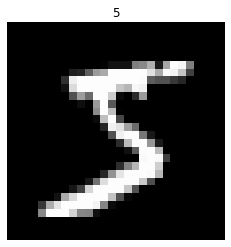

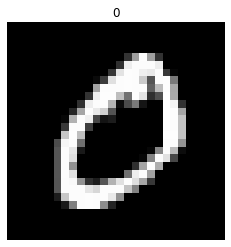

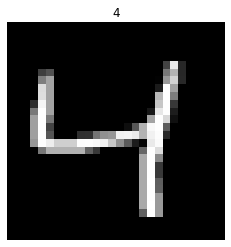

In [1]:
# load in MNIST dataset
%matplotlib inline

import nengo
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import nengo_dl

def load_mnist(plot=False, n_steps=30):
    (train_images, train_labels), (test_images, test_labels) = (
        tf.keras.datasets.mnist.load_data())

    # flatten images
    train_images = train_images.reshape((train_images.shape[0], -1))
    test_images = test_images.reshape((test_images.shape[0], -1))

    if plot:
        for i in range(3):
            plt.figure()
            plt.imshow(np.reshape(train_images[i], (28, 28)),
                       cmap="gray")
            plt.axis('off')
            plt.title(str(train_labels[i]));

    # add single timestep to training data
    train_images = train_images[:, None, :]
    train_labels = train_labels[:, None, None]

    # when testing our network with spiking neurons we will need to run it
    # over time, so we repeat the input/target data for a number of timesteps.
    test_images = np.tile(test_images[:, None, :], (1, n_steps, 1))
    test_labels = np.tile(test_labels[:, None, None], (1, n_steps, 1))

    return train_images, train_labels, test_images, test_labels

minibatch_size = 200
train_images, train_labels, test_images, test_labels = load_mnist(plot=True)

In [2]:
# Using a converted ConvNet Keras network in NengoDL
tf.random.set_seed(0)

input = tf.keras.Input(shape=(28, 28, 1), batch_size=minibatch_size)
conv1 = tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=3,
    activation=tf.nn.relu,
)(input)
flatten = tf.keras.layers.Flatten()(conv1)
dense1 = tf.keras.layers.Dense(units=10)(flatten)
model = tf.keras.Model(inputs=input, outputs=dense1)

In [1]:
converter = nengo_dl.Converter(
    model,
    swap_activations={tf.nn.relu: nengo.RectifiedLinear()},
)
net = converter.net

nengo_input = converter.inputs[input]
nengo_output = converter.outputs[dense1]

nengo_conv1 = converter.layers[conv1]
with converter.net as net:
    probe_conv1 = nengo.Probe(nengo_conv1, label='probe_conv1')

# run training
with nengo_dl.Simulator(net, minibatch_size=minibatch_size, seed=0) as sim:
    
    sim.compile(
        optimizer=tf.optimizers.RMSprop(0.001),
        loss={nengo_output: tf.losses.SparseCategoricalCrossentropy(from_logits=True)},
    )
    
    sim.fit(train_images, {nengo_output: train_labels}, epochs=10)

    # save the parameters to file
    sim.save_params("mnist_params")

NameError: name 'nengo_dl' is not defined

In [3]:
# test gain scaling with non-spiking neurons
def run_network(activation, params_file, gain_scale=1, synapse=None):
    converter = nengo_dl.Converter(
        model,
        swap_activations={tf.nn.relu: activation},
        scale_firing_rates=gain_scale,
    )
    net = converter.net

    nengo_input = converter.inputs[input]
    nengo_output = converter.outputs[dense1]

    nengo_conv1 = converter.layers[conv1]
    with net:
        probe_conv1 = nengo.Probe(nengo_conv1)
        
    if synapse is not None:
        for conn in net.all_connections:
            conn.synapse = synapse

    n_test = 5
    with nengo_dl.Simulator(net, minibatch_size=1, seed=0) as sim:
        sim.load_params(params_file)
        data = sim.predict({nengo_input: test_images[:n_test]})

    # plot network predictions
    plt.figure()
    plt.plot(test_labels[:n_test].squeeze(), 'rx', mew=15)
    plt.plot(np.argmax(data[nengo_output][:, -1], axis=1), 'o', mew=2)
    plt.grid()
    plt.ylabel('Digit')
    plt.xlabel('Batch')
    plt.ylim([-.5, 9.5])
    plt.xticks(range(5), range(5))
    plt.yticks(range(10), range(10))
    plt.title('Network predictions')

    # plot neural activity
    plt.figure()
    n_neurons = 5000
    activity = data[probe_conv1]
    if activation == nengo.SpikingRectifiedLinear():
        activity = activity * 0.001 * gain_scale
    print('Max value: ', np.max(activity.flatten()))
    plt.plot(activity[:, :, :n_neurons].reshape(-1, n_neurons))
    plt.title('Neuron activity')
    
    # plot raw network output (the first 5 dimensions)
    plt.figure()
    for ii in range(5):
        plt.subplot(5, 1, ii+1)
        plt.plot(data[nengo_output][0].reshape(-1, 10)[:, ii])
        plt.ylabel('%i' % ii)
    plt.tight_layout()
    plt.title('Network output')

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
Max value:  28.099272


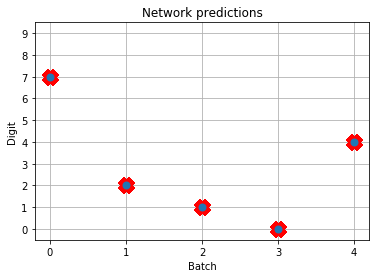

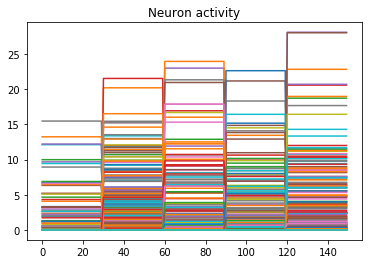

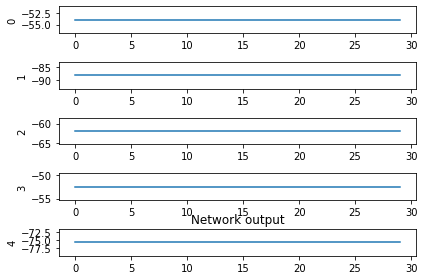

In [101]:
# run the network in rate mode
run_network(
    activation=nengo.RectifiedLinear(),
    params_file='mnist_params')

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
Max value:  0.0


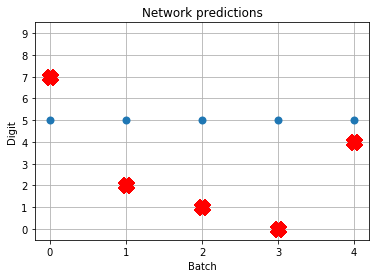

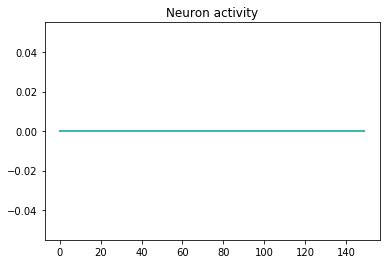

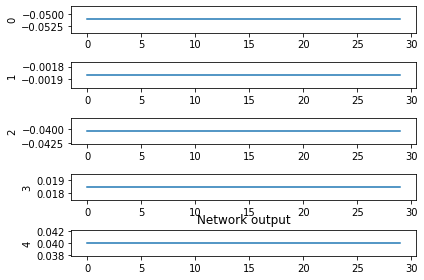

In [102]:
# run the network with spiking neurons
run_network(
    activation=nengo.SpikingRectifiedLinear(),
    params_file='mnist_params',
)

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
Max value:  1.0


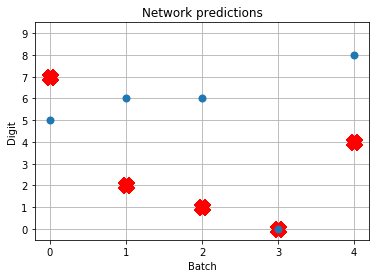

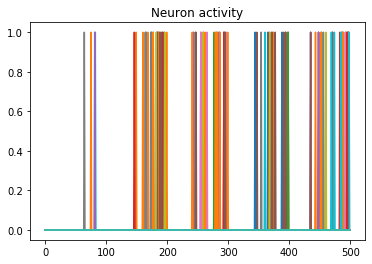

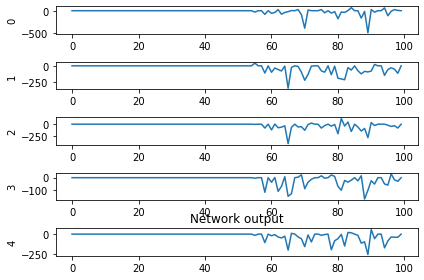

In [103]:
# run the network with spiking neurons showing each input for 100ms
train_images, train_labels, test_images, test_labels = load_mnist(plot=False, n_steps=100)
run_network(
    activation=nengo.SpikingRectifiedLinear(),
    params_file='mnist_params',
)

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
Max value:  1.0
Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:01                                               
Max value:  1.0
Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
Max value:  1.0


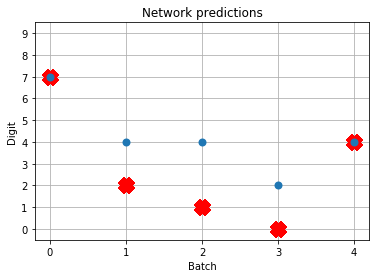

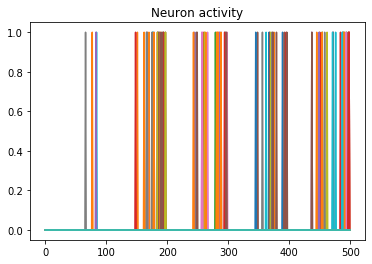

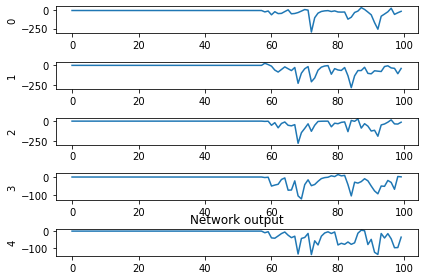

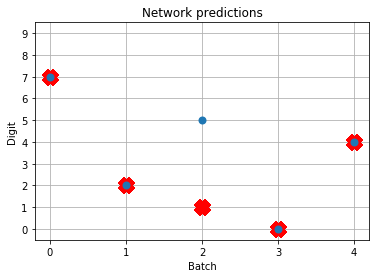

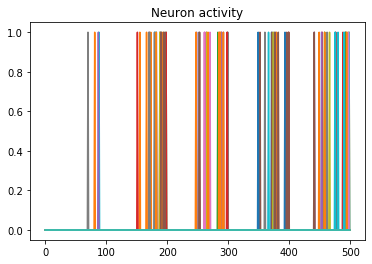

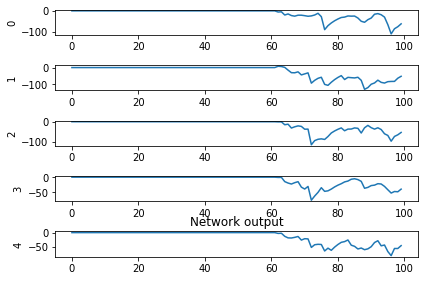

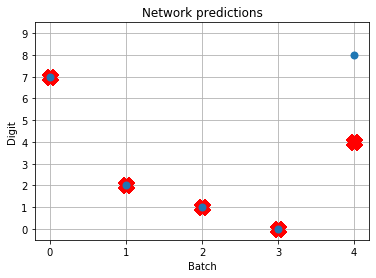

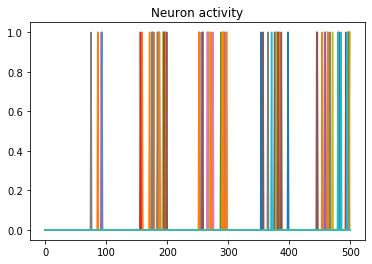

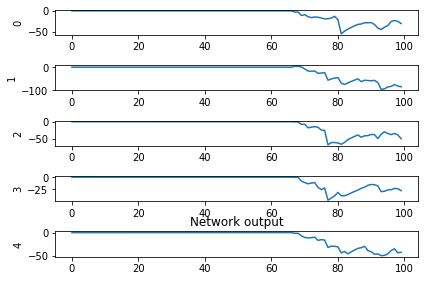

In [104]:
# run the network with spiking neurons showing each input for 100ms and using synapses
for synapse in [0.001, 0.005, 0.01]:
    run_network(
        activation=nengo.SpikingRectifiedLinear(),
        params_file='mnist_params',
        synapse=synapse,
    )

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
Max value:  0.0
Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
Max value:  1.0
Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
Max value:  1.0


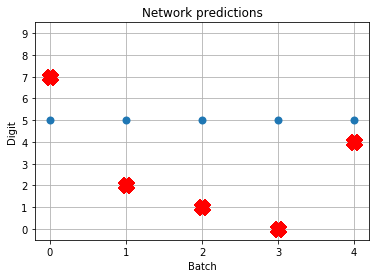

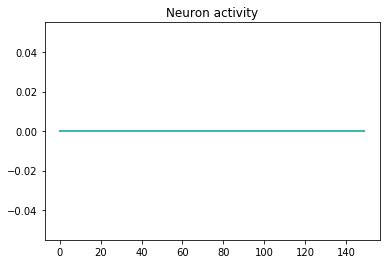

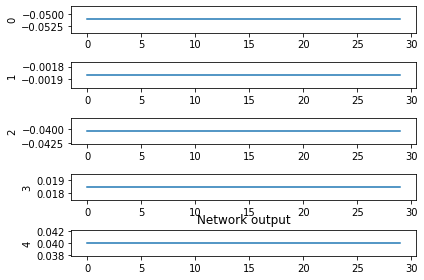

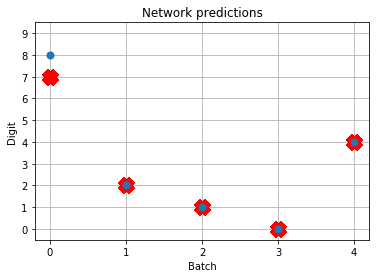

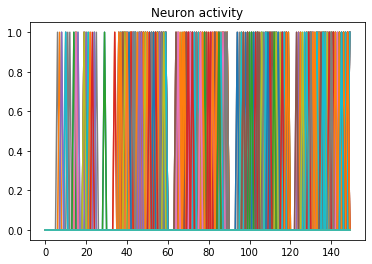

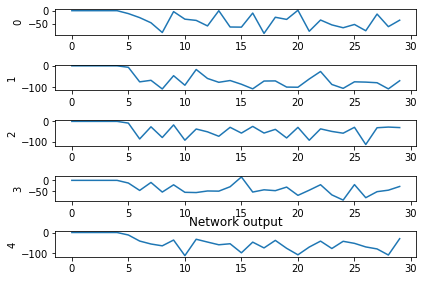

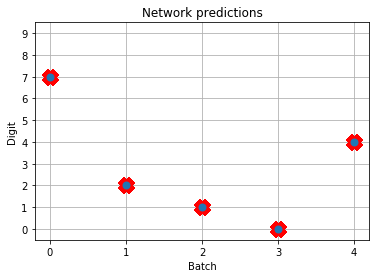

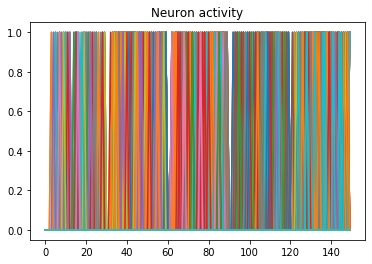

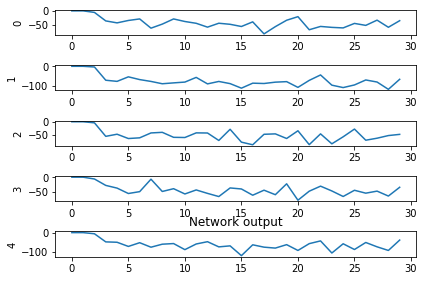

In [108]:
# test gain scaling with spiking neurons showing each input for 30ms
train_images, train_labels, test_images, test_labels = load_mnist(plot=False, n_steps=30)
for gain_scale in [1, 10, 20]:
    run_network(
        activation=nengo.SpikingRectifiedLinear(),
        params_file='mnist_params',
        gain_scale=gain_scale
    )

In [ ]:
# Add term to cost function to penalizes neurons firing outside range 200-300

converter = nengo_dl.Converter(
    model,
    swap_activations={tf.nn.relu: nengo.RectifiedLinear()},
)
net = converter.net

nengo_input = converter.inputs[input]
nengo_output = converter.outputs[dense1]

nengo_conv1 = converter.layers[conv1]
with converter.net as net:
    probe_conv1 = nengo.Probe(nengo_conv1, label='probe_conv1')

def put_in_range(
        x, y, weight=100.0, min=200, max=300):
    assert len(y.shape) == 3
    index_greater = (y > max)
    index_lesser = (y < min)
    error = tf.reduce_sum(y[index_greater] - max) + tf.reduce_sum(min - y[index_lesser])
    return weight * error

# run training
with nengo_dl.Simulator(net, minibatch_size=minibatch_size, seed=0) as sim:
    
    sim.compile(
        optimizer=tf.optimizers.RMSprop(0.001),
        loss={nengo_output: tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              probe_conv1: put_in_range},
    )
    
    sim.fit(train_images, 
            {nengo_output: train_labels, 
             probe_conv1: np.zeros(train_labels.shape)},
            epochs=10)

    # save the parameters to file
    sim.save_params("mnist_params_with_fr_loss")

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
Max value:  469.76566


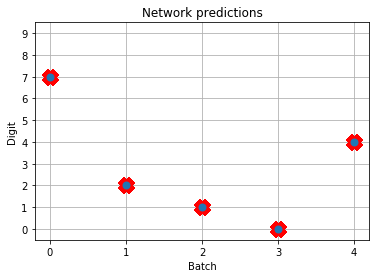

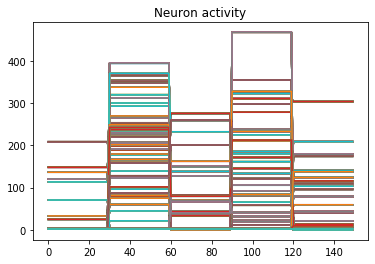

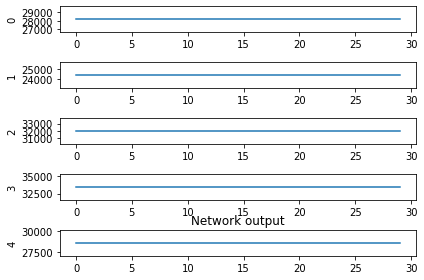

In [106]:
# run with rate neurons showing each input for 30ms
train_images, train_labels, test_images, test_labels = load_mnist(plot=False)
run_network(
    activation=nengo.RectifiedLinear(),
    params_file='mnist_params_with_fr_loss')

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
Max value:  1.0


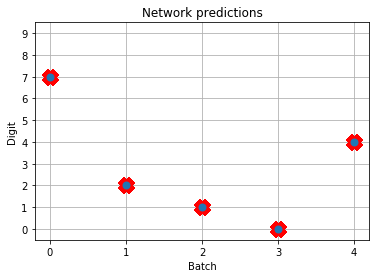

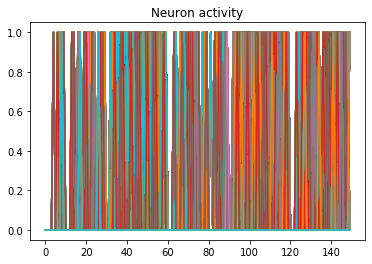

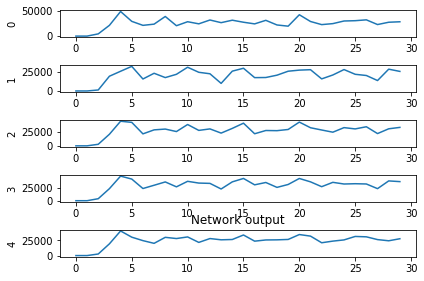

In [107]:
# run with spiking neurons showing each input for 30ms
run_network(
    activation=nengo.SpikingRectifiedLinear(),
    params_file='mnist_params_with_fr_loss',
)